# Explorative study on attenuation densities in the lungs

In [6]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from helper_functions import *


In [7]:
%%capture
# Import from different folder
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_preprocess_dir = os.path.join(parent_dir, "DataPreprocess")

sys.path.append(data_preprocess_dir)
from main_preprocess import load_nifti_convert_to_numpy

In [8]:
# Define paths
data_path = '/Users/bruger/Desktop/Bachelor/resampled_lung_pilot_data'
cropped_lung_ct_path = data_path + '/cropped_lungs_ct/*.nii.gz'
file_paths = glob.glob(cropped_lung_ct_path)

### Load data of attenuation arrays with vessels

In [9]:
# List the files in the attenuation directory
rows = []
for path in file_paths:
    arr = load_nifti_convert_to_numpy(input_path=path)
    arr = arr.flatten()
    patient_id = os.path.basename(path)[7:10]
    new_row = {
        'attenuation': arr,
        'patient': patient_id,
        'label': 'sick' if int(patient_id) < 14 else 'healthy',
        'average_attenuation': np.mean(arr),
        'hpdr': get_hpdr(arr),
    }
    rows.append(new_row)

In [ ]:
df = pd.DataFrame(rows).sort_values('patient')
df = df.reset_index(drop=True)
df

In [ ]:
df_with_vessels = df.copy()

In [ ]:
print(len(df_with_vessels['attenuation'][0]))
print(len(df_with_vessels['attenuation'][1]))


14384381
27831637


# Investigating attenuation

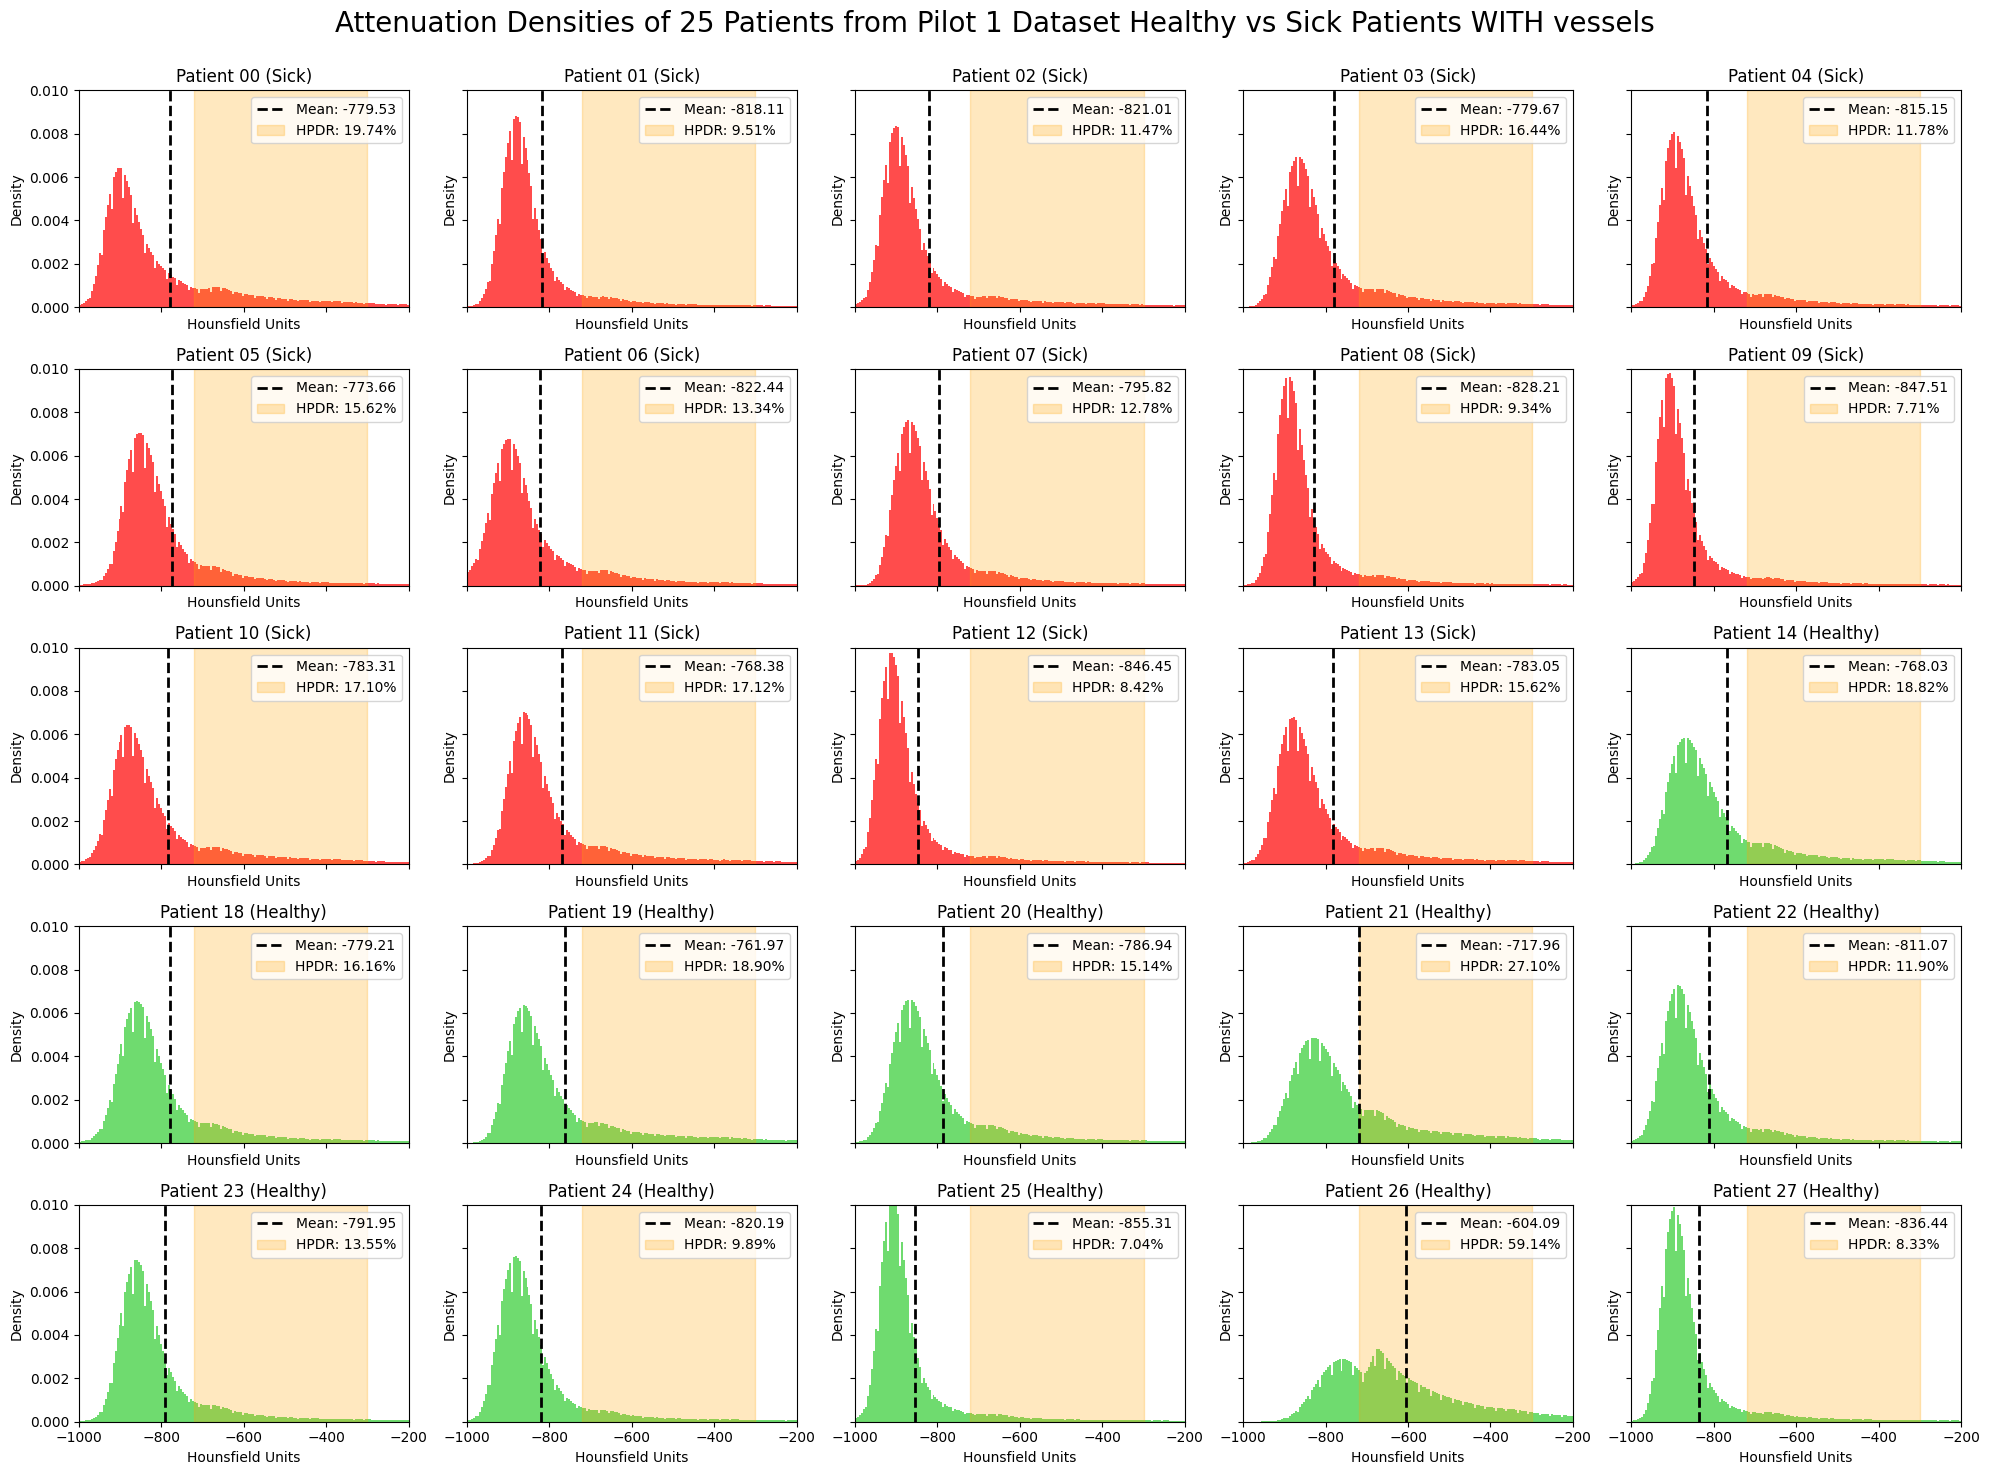

In [ ]:
# Calculate the number of plots required (5 columns per row)
total_patients = len(df_with_vessels)
cols = 5
rows = (total_patients + cols - 1) // cols  # Round up to nearest whole row

# Create a grid of subplots
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 3), sharex=True, sharey=True)

# Flatten axes to easily index into them
axes = axes.flatten()

# Define bins for all histograms
bins = np.linspace(-1000, 200, 250)

# Counter to track the subplot index
subplot_idx = 0

# Plot each patient's attenuation data
for _, row in df_with_vessels.iterrows():
    attenuation_data = row['attenuation']
    patient_id = row['patient']
    label = row['label']
    hpdr = row['hpdr']
    color = 'limegreen' if label == 'healthy' else 'red'
    
    axes[subplot_idx].hist(attenuation_data, bins=bins, alpha=0.7, density=True, color=color)
    axes[subplot_idx].set_title(f"Patient {patient_id} ({label.capitalize()})")
    axes[subplot_idx].set_xlabel("Hounsfield Units")
    axes[subplot_idx].set_ylabel("Density")
    axes[subplot_idx].set_ylim(0, 0.01)
    axes[subplot_idx].set_xlim(-1000, -200)
    HPDR = axes[subplot_idx].axvspan(-720, -300, color='orange', alpha=0.25)
    mean_value = np.mean(attenuation_data)
    mean_line = axes[subplot_idx].axvline(mean_value, color='black', linestyle='--', linewidth=2)
    axes[subplot_idx].legend([mean_line,HPDR],[f'Mean: {mean_value:.2f}', f"HPDR: {hpdr * 100:.2f}%"], loc="upper right")
    #ax.legend([f'Mean: {mean_value:.2f}', f"HPDR: {hpdr_percent * 100:.2f}%"], loc="upper right")
    subplot_idx += 1

# Turn off unused axes
for i in range(subplot_idx, len(axes)):
    axes[i].axis('off')

plt.suptitle('attenuation Densities of 25 Patients from Pilot 1 Dataset Healthy vs Sick Patients WITH vessels', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

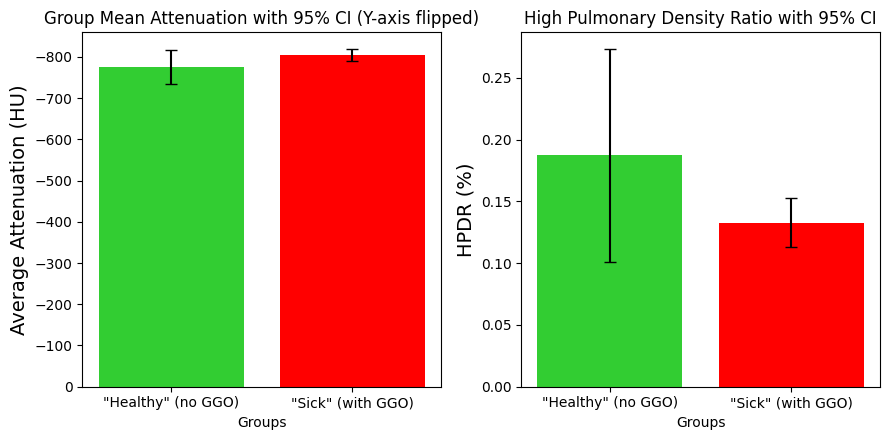

In [ ]:

# Calculate mean and standard error for attenuation
group_mean_attenuation = df_with_vessels.groupby('label')['average_attenuation'].mean()
group_sem_attenuation = df_with_vessels.groupby('label')['average_attenuation'].sem()

# Calculate 95% confidence interval range for attenuation
ci_attenuation = 1.96 * group_sem_attenuation

# Calculate mean and standard error for HPDR
group_mean_hpdr = df_with_vessels.groupby('label')['hpdr'].mean()
group_sem_hpdr = df_with_vessels.groupby('label')['hpdr'].sem()

# Calculate 95% confidence interval range for HPDR
ci_hpdr = 1.96 * group_sem_hpdr

# Define colors for each group (same for both plots)
colors = ['limegreen' if label == 'healthy' else 'red' for label in group_mean_attenuation.index]

# Define custom x-axis labels
custom_labels = ['"Healthy" (no GGO)', '"Sick" (with GGO)']

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4.5))

# Plot 1: attenuation with flipped y-axis
ax1.bar(x=group_mean_attenuation.index, height=group_mean_attenuation, yerr=ci_attenuation, capsize=4, color=colors)
ax1.set_xlabel('Groups')
ax1.set_ylabel('Average attenuation (HU)', fontsize=14)
ax1.set_title('Group Mean attenuation with 95% CI (Y-axis flipped)')
ax1.invert_yaxis()  # Flip the y-axis

# Set x-ticks and labels for the first plot
ax1.set_xticks(np.arange(len(group_mean_attenuation)))  # Set the x-ticks based on the number of groups
ax1.set_xticklabels(custom_labels) 

# Plot 2: HPDR
ax2.bar(x=group_mean_hpdr.index, height=group_mean_hpdr, yerr=ci_hpdr, capsize=4, color=colors)
ax2.set_xlabel('Groups')
ax2.set_ylabel('HPDR (%)', fontsize=14)
ax2.set_title('High Pulmonary Density Ratio with 95% CI')

# Set x-ticks and labels for the second plot
ax2.set_xticks(np.arange(len(group_mean_hpdr)))  # Set the x-ticks based on the number of groups
ax2.set_xticklabels(custom_labels) 

# Adjust layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()